# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(degrees=(-10,10), resample=False, expand=False, center=None, fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
train_loader

In [0]:
print(test.data.shape,train.data.shape)


torch.Size([10000, 28, 28]) torch.Size([60000, 28, 28])


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

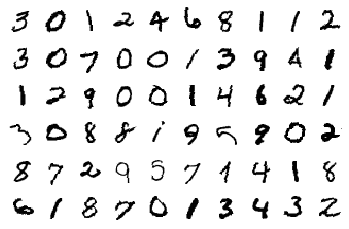

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
train.data.shape

torch.Size([60000, 28, 28])

# The model
Let's start with the model we first saw

In [0]:
class conv_block(nn.Module):

  def __init__(self,in_channels,out_channels,kernel_size=(3,3),dropout=0.1,**kwargs):
    super(conv_block, self).__init__()
    self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,**kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
    # self.out_channels=out_channels
  def forward(self,x):
    return self.convblock(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1=conv_block(in_channels=1,out_channels=10,padding=0)
        self.conv2=conv_block(in_channels=10,out_channels=16,padding=0)
        self.conv3=conv_block(in_channels=16,out_channels=24,padding=0)
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.conv4=conv_block(in_channels=24,out_channels=10,padding=0,kernel_size=(1,1))
        self.conv5=conv_block(in_channels=10,out_channels=16,padding=0)
        self.conv6=conv_block(in_channels=16,out_channels=16,padding=0)
        self.conv7=conv_block(in_channels=16,out_channels=14,dropout=0.0,padding=0)
        self.conv8=conv_block(in_channels=14,out_channels=10,dropout=0.0,kernel_size=(5,5),padding=0)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x= self.conv3(x)
        x = self.pool1(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x= self.conv7(x)

        x=self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
# import numpy as np
a=conv_block(in_channels=1,out_channels=10,padding=0)(images).shape



# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
        conv_block-5           [-1, 10, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,456
       BatchNorm2d-7           [-1, 16, 24, 24]              32
              ReLU-8           [-1, 16, 24, 24]               0
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
           Conv2d-11           [-1, 24, 22, 22]           3,480
      BatchNorm2d-12           [-1, 24, 22, 22]              48
             ReLU-13           [-1, 24, 22, 22]               0
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm_notebook,tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader,position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # print(data.shape)
    # Init
    # scheduler.step()
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    # scheduler.step()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    # print(f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
list(model.parameters())[0].shape

torch.Size([10, 1, 3, 3])

In [0]:
from torch.optim.lr_scheduler import StepLR

In [0]:
model =  Net().to(device)

# Let's Train and test our model

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 10
for epoch in range(EPOCHS):
    scheduler.step()

    print(f"EPOCH = {epoch} lr={scheduler.get_lr()}")
    
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH = 0 lr=[0.01]


Loss=0.12675048410892487 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0758, Accuracy: 9841/10000 (98.41%)

EPOCH = 1 lr=[0.01]


Loss=0.07953546941280365 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9880/10000 (98.80%)

EPOCH = 2 lr=[0.01]


Loss=0.05455906689167023 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9883/10000 (98.83%)

EPOCH = 3 lr=[0.01]


Loss=0.05254266783595085 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:12<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9906/10000 (99.06%)

EPOCH = 4 lr=[0.01]


Loss=0.06784646958112717 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9913/10000 (99.13%)

EPOCH = 5 lr=[0.0001]


Loss=0.03933335840702057 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9929/10000 (99.29%)

EPOCH = 6 lr=[0.001]


Loss=0.06559336185455322 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9925/10000 (99.25%)

EPOCH = 7 lr=[0.001]


Loss=0.021164918318390846 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 41.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

EPOCH = 8 lr=[0.001]


Loss=0.10276498645544052 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9933/10000 (99.33%)

EPOCH = 9 lr=[0.001]


Loss=0.04222714900970459 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:12<00:00, 37.59it/s]



Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)



In [0]:
optimizer

In [0]:
model(images.cuda()).shape

torch.Size([1152, 10])

Text(0.5, 1.0, 'Test Accuracy')

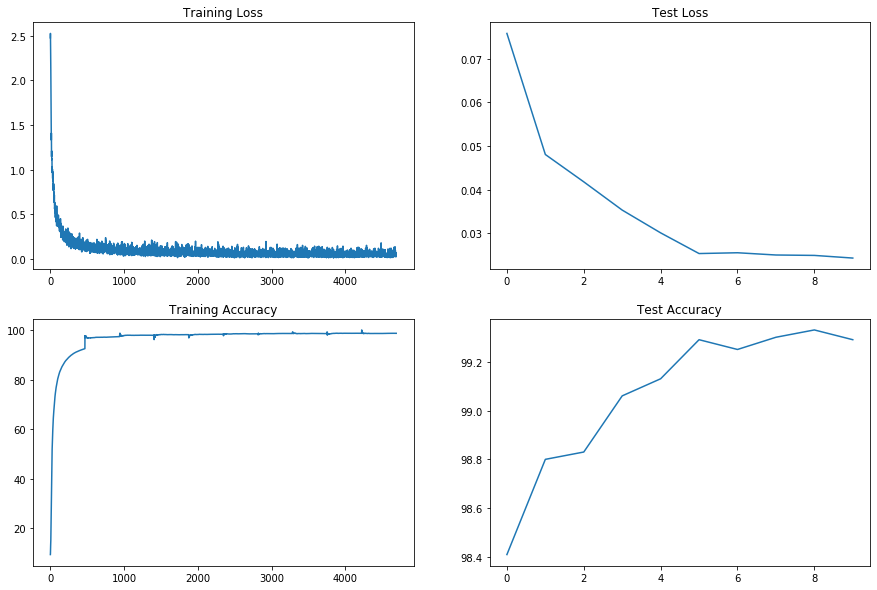

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")